In [1]:
# starting point: take "../transition-to-flux/second-refactor" setup and try to run ADAM on it

┌ Warning: This version of CUDA.jl only supports NVIDIA drivers for CUDA 10.1 or higher (yours is for CUDA 9.1.0)
└ @ CUDA C:\Users\Fluid3\.julia\packages\CUDA\M4jkK\src\initialization.jl:100


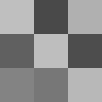

In [2]:
using Flux
import TestImages: testimage
import ImageView: imshow
import Images: Gray
img = testimage("mandrill")
im0 = 1*Gray.(img)
import ImageTransformations: imresize
im3 = imresize(im0, 3, 3)

In [3]:
# we are going to do the same or similar ops for a small matrix and for a large one
# and this way if any problems arise, we'll know if it's logic or size
m_im0 = convert(Matrix{Float32}, im0)
m_im3 = convert(Matrix{Float32}, im3)

3×3 Matrix{Float32}:
 0.749673  0.286601  0.689869
 0.378105  0.743137  0.302288
 0.515142  0.466993  0.72146

In [4]:
function warp3(x, y, p) # 0:31
    knob = p[:knob]
    clip(n, nsize) = max(min(nsize, n), 1)
    (xnew, ynew) =
        # clip(convert(Int, floor(x - 10 * (knob / 32) * sin(y/4))), xsize), y), # currently unused variant
        # clip(convert(Int, floor(x + 10 * ((knob - 16) / 16) * sin(y/4))), xsize), y) # normalize to get +/-
        (clip(x + 10 * ((knob - 16) / 16) * sin(y/4), p[:xsize]), y)
    xnew, ynew
end

warp3 (generic function with 1 method)

In [5]:
function apply_warp(warp, im, p)
    (xsize, ysize) = size(im)
    p[:xsize] = xsize
    p[:ysize] = ysize
    function linear_interpolation(x_y)
        # a rough draft, this can be improved; works on im
        x = x_y[1]
        y = x_y[2]
        dx=mod(x,1)
        dy=mod(y,1)
        x_left = floor(Int,x)
        y_left = floor(Int,y)
        x_right = min(x_left + 1, xsize)
        y_right = min(y_left + 1, ysize)
        im[x_left,y_left]*(1-dx)*(1-dy) + im[x_left,y_right]*(1-dx)*dy + im[x_right,y_left]*dx*(1-dy) + im[x_right, y_right]*dx*dy
    end
    [linear_interpolation(warp(x,y,p)) for x in 1:xsize, y in 1:ysize]
end

apply_warp (generic function with 1 method)

In [6]:
pars = Dict(:knob=>0, :dummy=>0.0)
# at least one of the above should be float and not integer, so that the dictionary type is
# Dict{Symbol, Real}  and not Dict{Symbol, Int64}

Dict{Symbol, Real} with 2 entries:
  :dummy => 0.0
  :knob  => 0

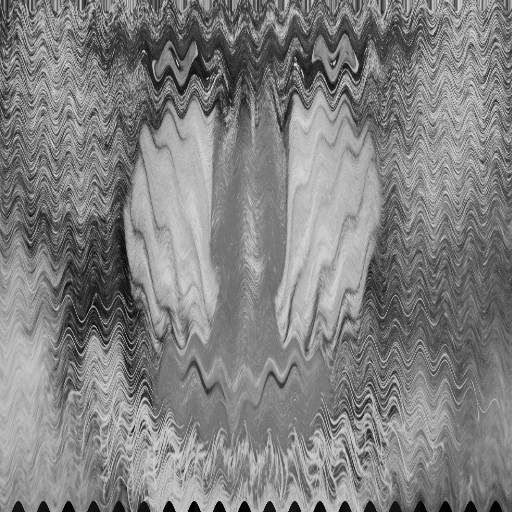

In [7]:
m_im0_warped = apply_warp(warp3, m_im0, pars)
Gray.(m_im0_warped)

In [8]:
# scale image so that all points brightness are between 0 and 1, and that full range is used
# we are going to use this on plain matrices and not on images, so this code changed at second-refactor
function normalize_image(im)
    im_res = im .- minimum(im)
    return (1/maximum(im_res))*im_res
end

normalize_image (generic function with 1 method)

In [9]:
import LinearAlgebra: transpose

In [10]:
norm_columns(f, x) = f.(x) ./ (sum(f.(x), dims=1))

norm_columns (generic function with 1 method)

In [11]:
# this version returns an ordinary matrix, does not try to produce an image
# this is introduced in second-refactor
norm_image_columns(f, x) = normalize_image(norm_columns(f, x))

norm_image_columns (generic function with 1 method)

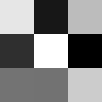

In [12]:
m_im3_norm = norm_image_columns(x -> x+1, m_im3)
Gray.(m_im3_norm)

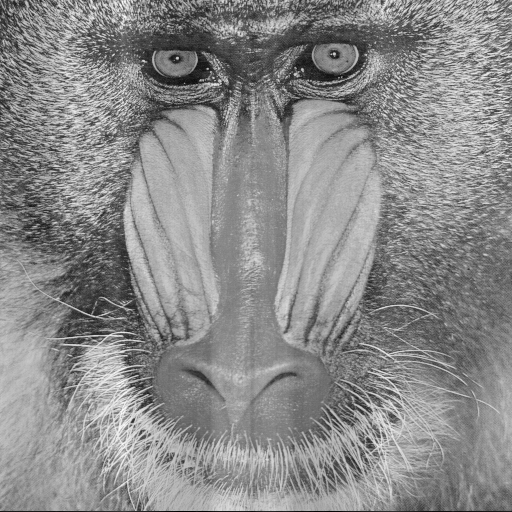

In [13]:
m_im0_norm = norm_image_columns(x -> x+1, m_im0)
Gray.(m_im0_norm)

In [14]:
transposed_product(x) = normalize_image(transpose(x)*x)

transposed_product (generic function with 1 method)

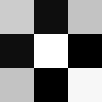

In [15]:
p_m_im3_norm = transposed_product(m_im3_norm)
Gray.(p_m_im3_norm)

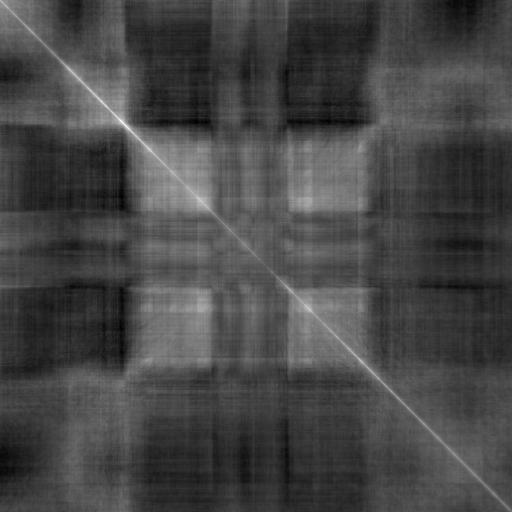

In [16]:
p_m_im0_norm = transposed_product(m_im0_norm)
Gray.(p_m_im0_norm)

In [17]:
m_im3_warped = deepcopy(m_im3)

3×3 Matrix{Float32}:
 0.749673  0.286601  0.689869
 0.378105  0.743137  0.302288
 0.515142  0.466993  0.72146

In [18]:
m_im3_warped[1,2] = m_im3_warped[2,2]
m_im3_warped[2,2] = m_im3_warped[3,2]
m_im3_warped[3,2] = 0

0

In [19]:
m_im3_warped

3×3 Matrix{Float32}:
 0.749673  0.743137  0.689869
 0.378105  0.466993  0.302288
 0.515142  0.0       0.72146

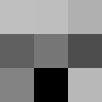

In [20]:
Gray.(m_im3_warped)

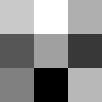

In [21]:
m_im3_warped_norm = norm_image_columns(x -> x+1, m_im3_warped)
Gray.(m_im3_warped_norm)

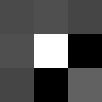

In [22]:
p_m_im3_warped_norm = transposed_product(m_im3_warped_norm)
Gray.(p_m_im3_warped_norm)

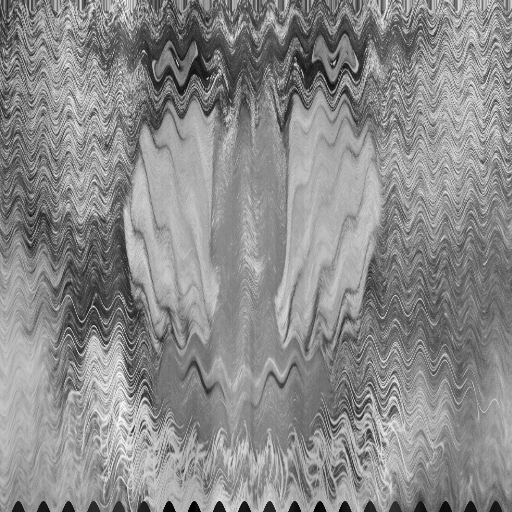

In [23]:
m_im0_warped_norm = norm_image_columns(x -> x+1, m_im0_warped)
Gray.(m_im0_warped_norm)

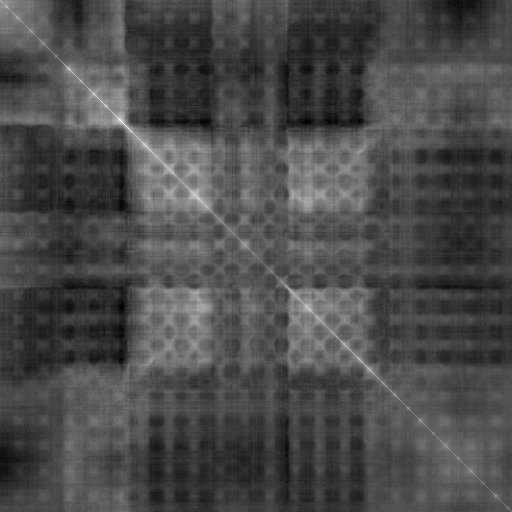

In [24]:
p_m_im0_warped_norm = transposed_product(m_im0_warped_norm)
Gray.(p_m_im0_warped_norm)

In [25]:
import LinearAlgebra: norm

In [26]:
value3(A) = transposed_product(norm_image_columns(x -> x+1, A))

value3 (generic function with 1 method)

In [27]:
loss(x, y) = norm(value3(x) - y)

loss (generic function with 1 method)

In [28]:
loss_small = loss(m_im3, p_m_im3_warped_norm)

1.1058546f0

In [29]:
loss_small * loss_small

1.2229145f0

In [30]:
loss_small^2

1.2229145f0

In [31]:
import LinearAlgebra: dot

In [32]:
loss2(x, y) = dot(value3(x) - y, value3(x) - y)

loss2 (generic function with 1 method)

In [33]:
loss2(m_im3, p_m_im3_warped_norm)

1.2229145f0

In [34]:
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}())

In [35]:
# I think I want a custom-made training loop instead of train! from
# https://github.com/FluxML/Flux.jl/blob/master/src/optimise/train.jl

In [36]:
small_ms = []

Any[]

In [37]:
import Flux.Optimise: update!

In [38]:
function step!(x, y, loss, opt, accum)
    p = params(x)
    push!(accum, deepcopy(x)) # I am unhappy about the loss of intermediate parameter values
    grads = gradient(()->loss(x, y), p)
    update!(opt, p, grads)
    loss(x, y)
end

step! (generic function with 1 method)

In [39]:
m_im3_copy = deepcopy(m_im3)

3×3 Matrix{Float32}:
 0.749673  0.286601  0.689869
 0.378105  0.743137  0.302288
 0.515142  0.466993  0.72146

In [49]:
loss(m_im3, p_m_im3_warped_norm)

1.1058546f0

In [40]:
step!(m_im3, p_m_im3_warped_norm, loss, opt, small_ms)

1.0901217f0

In [41]:
loss(m_im3, p_m_im3_warped_norm)

1.0901217f0

In [673]:
# let's click a few time
step!(m_im3, p_m_im3_warped_norm, loss, opt, small_ms)

0.0009998509f0

In [674]:
length(small_ms)

628

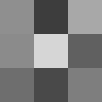

In [675]:
Gray.(m_im3)

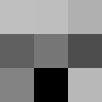

In [676]:
Gray.(m_im3_warped)

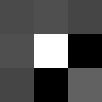

In [677]:
Gray.(value3(m_im3))

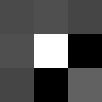

In [678]:
Gray.(p_m_im3_warped_norm)

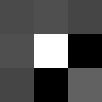

In [679]:
Gray.(value3(m_im3_warped))

In [380]:
# it seems likely that this one does converge to a global minimum, and that this global minimum is not unique

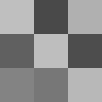

In [680]:
Gray.(small_ms[1])

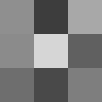

In [681]:
Gray.(small_ms[628])

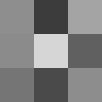

In [682]:
Gray.(small_ms[314])

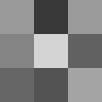

In [683]:
Gray.(small_ms[157])

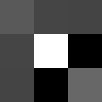

In [685]:
Gray.(value3(small_ms[157]))

In [686]:
large_ms = [] # of course, our idea to store all intermediate matrices is highly questionable, we'll adjust this

Any[]

In [687]:
opt2 = ADAM() # the easiest way to surely reset the optimizer is to create another copy

ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}())

In [688]:
m_im0_copy = deepcopy(m_im0)

512×512 Matrix{Float32}:
 0.568627   0.219608   0.192157   0.34902   …  0.443137  0.6        0.694118
 0.454902   0.396078   0.156863   0.262745     0.509804  0.584314   0.490196
 0.301961   0.447059   0.180392   0.180392     0.392157  0.345098   0.317647
 0.278431   0.533333   0.372549   0.188235     0.286275  0.294118   0.27451
 0.341176   0.478431   0.517647   0.196078     0.231373  0.313726   0.337255
 0.321569   0.298039   0.623529   0.239216  …  0.333333  0.596078   0.713726
 0.168627   0.2        0.52549    0.509804     0.72549   0.776471   0.643137
 0.129412   0.2        0.435294   0.6          0.631373  0.470588   0.541176
 0.223529   0.188235   0.219608   0.458824     0.529412  0.611765   0.478431
 0.14902    0.12549    0.188235   0.25098      0.254902  0.317647   0.533333
 0.129412   0.168627   0.223529   0.145098  …  0.254902  0.286275   0.266667
 0.129412   0.184314   0.305882   0.141176     0.34902   0.290196   0.294118
 0.141176   0.262745   0.352941   0.254902     0.301

In [689]:
loss(m_im0, p_m_im0_warped_norm)

20.39865222030749

In [690]:
step!(m_im0, p_m_im0_warped_norm, loss, opt2, large_ms)

18.9305199942761

In [691]:
loss(m_im0, p_m_im0_warped_norm)

18.9305199942761

In [934]:
# let's click a few times
step!(m_im0, p_m_im0_warped_norm, loss, opt2, large_ms)

1.111619282630947

In [935]:
length(large_ms)

227

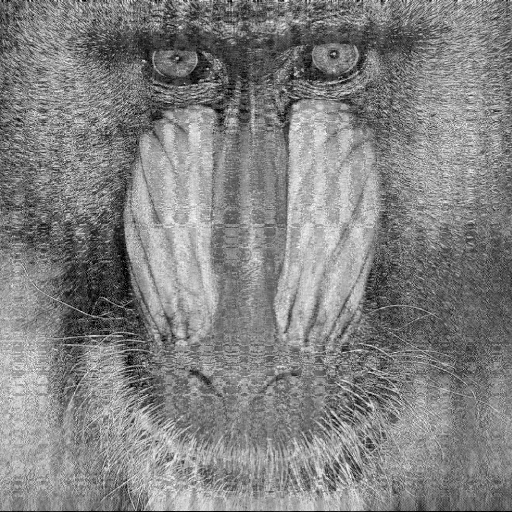

In [936]:
Gray.(m_im0)

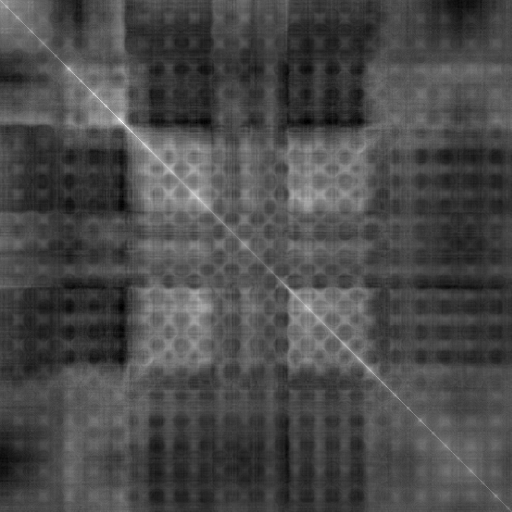

In [937]:
Gray.(value3(m_im0))

In [938]:
# ADAM converges confidently approximately up-to-here
# Of course, visually it reached the solution long ago
# (and the convergence might resume)

# We again see that this task has multiple solutions/multiple global minuma

# I am pretty happy about the achieved result (it turned out that a smaller, 
# milder change than "warp3" yields comparable effects in the "value3" appearance)